# CUDA Convolution Benchmark (Colab - Tesla T4)

This notebook builds the CUDA convolution code and benchmarks multiple image sizes and iteration counts on Colab.

In [43]:
!nvidia-smi
!nvidia-smi --query-gpu=name --format=csv,noheader

Wed Feb  4 08:51:14 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Ghi chú GPU/Toolchain
Nếu gặp lỗi `the provided PTX was compiled with an unsupported toolchain`, hãy chạy cell kế tiếp để lấy compute capability và tắt PTX JIT. Cell compile bên dưới sẽ dùng đúng `SM`/`COMPUTE`.

In [44]:
import os
import subprocess
import shutil

def query_compute_cap():
    if shutil.which("nvidia-smi") is None:
        return None
    result = subprocess.run(
        "nvidia-smi --query-gpu=compute_cap --format=csv,noheader",
        shell=True,
        text=True,
        capture_output=True
    )
    if result.returncode != 0:
        return None
    cc = result.stdout.strip().splitlines()
    if not cc:
        return None
    return cc[0].strip()

cc = query_compute_cap()
if cc is None:
    cc = "7.5"  # default for Tesla T4
    print("Warning: cannot query compute capability; using default", cc)

sm = "sm_" + cc.replace(".", "")
compute = "compute_" + cc.replace(".", "")
os.environ["SM"] = sm
os.environ["COMPUTE"] = compute
os.environ["CUDA_DISABLE_PTX_JIT"] = "1"
print("Compute capability:", cc, "=>", sm, compute)

Compute capability: 7.5 => sm_75 compute_75


In [45]:
import os
import shutil
import subprocess

def ensure_nvcc():
    nvcc = shutil.which("nvcc")
    if nvcc:
        return nvcc
    if os.path.exists("/usr/local/cuda/bin/nvcc"):
        os.environ["PATH"] = "/usr/local/cuda/bin:" + os.environ.get("PATH", "")
        return "/usr/local/cuda/bin/nvcc"
    if os.path.exists("/usr/lib/cuda/bin/nvcc"):
        os.environ["PATH"] = "/usr/lib/cuda/bin:" + os.environ.get("PATH", "")
        return "/usr/lib/cuda/bin/nvcc"

    print("nvcc not found; installing nvidia-cuda-toolkit (may take a few minutes)...")
    subprocess.run("apt-get update -qq", shell=True, check=True)
    subprocess.run("apt-get install -y -qq nvidia-cuda-toolkit", shell=True, check=True)
    return shutil.which("nvcc")

nvcc = ensure_nvcc()
if not nvcc:
    raise RuntimeError("nvcc still not found. Ensure Colab GPU runtime is enabled.")

os.environ["NVCC"] = nvcc
print("Using NVCC:", nvcc)
subprocess.run([nvcc, "--version"], check=False)

Using NVCC: /usr/local/cuda/bin/nvcc


CompletedProcess(args=['/usr/local/cuda/bin/nvcc', '--version'], returncode=0)

In [46]:
%%writefile funcs.h
#ifndef FUNCS_H
#define FUNCS_H

#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define CUDA_SAFE_CALL(call) {                                     \
    cudaError err = call;                                          \
    if (cudaSuccess != err) {                                      \
        fprintf(stderr, "Cuda error in file '%s' in line %i : %s.\n", \
                __FILE__, __LINE__, cudaGetErrorString(err));      \
        exit(EXIT_FAILURE);                                        \
    }                                                              \
}

#define FRACTION_CEILING(numerator, denominator) ((numerator + denominator - 1) / (denominator))

typedef enum { RGB, GREY } color_t;

#ifdef __cplusplus
extern "C" {
#endif

int write_all(int fd, uint8_t *buff, int size);
int read_all(int fd, uint8_t *buff, int size);
void Usage(int argc, char **argv, char **image, int *width, int *height, int *loops, color_t *imageType);
uint64_t micro_time(void);

#ifdef __cplusplus
}
#endif

#endif

Overwriting funcs.h


In [47]:
%%writefile funcs.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <fcntl.h>
#include <unistd.h>
#include <stdint.h>
#include <assert.h>
#include <sys/time.h>
#include "funcs.h"

void Usage(int argc, char **argv, char **image, int *width, int *height, int *loops, color_t *imageType) {
    int has_noout = (argc == 7 && !strcmp(argv[6], "noout"));
    if ((argc == 6 || has_noout) && !strcmp(argv[5], "grey")) {
        *image = (char *)malloc((strlen(argv[1]) + 1) * sizeof(char));
        strcpy(*image, argv[1]);
        *width = atoi(argv[2]);
        *height = atoi(argv[3]);
        *loops = atoi(argv[4]);
        *imageType = GREY;
    } else if ((argc == 6 || has_noout) && !strcmp(argv[5], "rgb")) {
        *image = (char *)malloc((strlen(argv[1]) + 1) * sizeof(char));
        strcpy(*image, argv[1]);
        *width = atoi(argv[2]);
        *height = atoi(argv[3]);
        *loops = atoi(argv[4]);
        *imageType = RGB;
    } else {
        fprintf(stderr, "Error Input!\n%s image_name width height loops [rgb/grey] [noout].\n", argv[0]);
        exit(EXIT_FAILURE);
    }
}

int write_all(int fd, uint8_t* buff, int size) {
    int n, sent;
    for (sent = 0; sent < size; sent += n)
        if ((n = write(fd, buff + sent, size - sent)) == -1)
            return -1;
    return sent;
}

int read_all(int fd, uint8_t* buff, int size) {
    int n, sent;
    for (sent = 0; sent < size; sent += n)
        if ((n = read(fd, buff + sent, size - sent)) == -1)
            return -1;
    return sent;
}

uint64_t micro_time(void) {
    struct timeval tv;
    assert(gettimeofday(&tv, NULL) == 0);
    return (uint64_t)tv.tv_sec * 1000 * 1000 + (uint64_t)tv.tv_usec;
}

Overwriting funcs.c


In [48]:
%%writefile cuda_convolute.h
#ifndef CUDA_CONVOLUTE_H
#define CUDA_CONVOLUTE_H

#include "funcs.h"

#ifdef __cplusplus
extern "C" {
#endif

void gpuConvolute(uint8_t *src, int width, int height, int loops, color_t imageType);

#ifdef __cplusplus
}
#endif

#endif


Overwriting cuda_convolute.h


In [49]:
%%writefile cuda_convolute.cu
#include <stdio.h>
#include <stdlib.h>
#include "cuda_convolute.h"
#include "funcs.h"
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#define BLOCK_SIZE 16

__device__ __constant__ int c_kernel[9];

__device__ __forceinline__ uint8_t div16_u8(int sum) {
    return (uint8_t)(sum >> 4);
}

__global__ void kernel_conv_grey(const uint8_t *__restrict__ src, uint8_t *__restrict__ dst, int width, int height) {
    __shared__ uint8_t tile[BLOCK_SIZE + 2][BLOCK_SIZE + 2];

    int x = blockIdx.x * BLOCK_SIZE + threadIdx.x;
    int y = blockIdx.y * BLOCK_SIZE + threadIdx.y;
    int tx = threadIdx.x + 1;
    int ty = threadIdx.y + 1;

    if (x < height && y < width) {
        tile[tx][ty] = src[width * x + y];
    } else {
        tile[tx][ty] = 0;
    }

    if (threadIdx.x == 0) {
        tile[0][ty] = (x > 0 && y < width) ? src[width * (x - 1) + y] : 0;
    }
    if (threadIdx.x == BLOCK_SIZE - 1) {
        tile[BLOCK_SIZE + 1][ty] = (x + 1 < height && y < width) ? src[width * (x + 1) + y] : 0;
    }
    if (threadIdx.y == 0) {
        tile[tx][0] = (y > 0 && x < height) ? src[width * x + (y - 1)] : 0;
    }
    if (threadIdx.y == BLOCK_SIZE - 1) {
        tile[tx][BLOCK_SIZE + 1] = (y + 1 < width && x < height) ? src[width * x + (y + 1)] : 0;
    }

    if (threadIdx.x == 0 && threadIdx.y == 0) {
        tile[0][0] = (x > 0 && y > 0) ? src[width * (x - 1) + (y - 1)] : 0;
    }
    if (threadIdx.x == 0 && threadIdx.y == BLOCK_SIZE - 1) {
        tile[0][BLOCK_SIZE + 1] = (x > 0 && y + 1 < width) ? src[width * (x - 1) + (y + 1)] : 0;
    }
    if (threadIdx.x == BLOCK_SIZE - 1 && threadIdx.y == 0) {
        tile[BLOCK_SIZE + 1][0] = (x + 1 < height && y > 0) ? src[width * (x + 1) + (y - 1)] : 0;
    }
    if (threadIdx.x == BLOCK_SIZE - 1 && threadIdx.y == BLOCK_SIZE - 1) {
        tile[BLOCK_SIZE + 1][BLOCK_SIZE + 1] =
            (x + 1 < height && y + 1 < width) ? src[width * (x + 1) + (y + 1)] : 0;
    }

    __syncthreads();

    if (x > 0 && x < height - 1 && y > 0 && y < width - 1) {
        int sum = 0;
        sum += tile[tx - 1][ty - 1] * c_kernel[0];
        sum += tile[tx - 1][ty] * c_kernel[1];
        sum += tile[tx - 1][ty + 1] * c_kernel[2];
        sum += tile[tx][ty - 1] * c_kernel[3];
        sum += tile[tx][ty] * c_kernel[4];
        sum += tile[tx][ty + 1] * c_kernel[5];
        sum += tile[tx + 1][ty - 1] * c_kernel[6];
        sum += tile[tx + 1][ty] * c_kernel[7];
        sum += tile[tx + 1][ty + 1] * c_kernel[8];
        dst[width * x + y] = div16_u8(sum);
    }
}

__global__ void kernel_conv_rgb(const uint8_t *__restrict__ src, uint8_t *__restrict__ dst, int width, int height) {
    __shared__ uchar3 tile[BLOCK_SIZE + 2][BLOCK_SIZE + 2];

    int x = blockIdx.x * BLOCK_SIZE + threadIdx.x;
    int y = blockIdx.y * BLOCK_SIZE + threadIdx.y;
    int tx = threadIdx.x + 1;
    int ty = threadIdx.y + 1;

    if (x < height && y < width) {
        int idx = (x * width + y) * 3;
        tile[tx][ty] = make_uchar3(src[idx], src[idx + 1], src[idx + 2]);
    } else {
        tile[tx][ty] = make_uchar3(0, 0, 0);
    }

    if (threadIdx.x == 0) {
        if (x > 0 && y < width) {
            int idx = ((x - 1) * width + y) * 3;
            tile[0][ty] = make_uchar3(src[idx], src[idx + 1], src[idx + 2]);
        } else {
            tile[0][ty] = make_uchar3(0, 0, 0);
        }
    }
    if (threadIdx.x == BLOCK_SIZE - 1) {
        if (x + 1 < height && y < width) {
            int idx = ((x + 1) * width + y) * 3;
            tile[BLOCK_SIZE + 1][ty] = make_uchar3(src[idx], src[idx + 1], src[idx + 2]);
        } else {
            tile[BLOCK_SIZE + 1][ty] = make_uchar3(0, 0, 0);
        }
    }
    if (threadIdx.y == 0) {
        if (y > 0 && x < height) {
            int idx = (x * width + (y - 1)) * 3;
            tile[tx][0] = make_uchar3(src[idx], src[idx + 1], src[idx + 2]);
        } else {
            tile[tx][0] = make_uchar3(0, 0, 0);
        }
    }
    if (threadIdx.y == BLOCK_SIZE - 1) {
        if (y + 1 < width && x < height) {
            int idx = (x * width + (y + 1)) * 3;
            tile[tx][BLOCK_SIZE + 1] = make_uchar3(src[idx], src[idx + 1], src[idx + 2]);
        } else {
            tile[tx][BLOCK_SIZE + 1] = make_uchar3(0, 0, 0);
        }
    }

    if (threadIdx.x == 0 && threadIdx.y == 0) {
        if (x > 0 && y > 0) {
            int idx = ((x - 1) * width + (y - 1)) * 3;
            tile[0][0] = make_uchar3(src[idx], src[idx + 1], src[idx + 2]);
        } else {
            tile[0][0] = make_uchar3(0, 0, 0);
        }
    }
    if (threadIdx.x == 0 && threadIdx.y == BLOCK_SIZE - 1) {
        if (x > 0 && y + 1 < width) {
            int idx = ((x - 1) * width + (y + 1)) * 3;
            tile[0][BLOCK_SIZE + 1] = make_uchar3(src[idx], src[idx + 1], src[idx + 2]);
        } else {
            tile[0][BLOCK_SIZE + 1] = make_uchar3(0, 0, 0);
        }
    }
    if (threadIdx.x == BLOCK_SIZE - 1 && threadIdx.y == 0) {
        if (x + 1 < height && y > 0) {
            int idx = ((x + 1) * width + (y - 1)) * 3;
            tile[BLOCK_SIZE + 1][0] = make_uchar3(src[idx], src[idx + 1], src[idx + 2]);
        } else {
            tile[BLOCK_SIZE + 1][0] = make_uchar3(0, 0, 0);
        }
    }
    if (threadIdx.x == BLOCK_SIZE - 1 && threadIdx.y == BLOCK_SIZE - 1) {
        if (x + 1 < height && y + 1 < width) {
            int idx = ((x + 1) * width + (y + 1)) * 3;
            tile[BLOCK_SIZE + 1][BLOCK_SIZE + 1] = make_uchar3(src[idx], src[idx + 1], src[idx + 2]);
        } else {
            tile[BLOCK_SIZE + 1][BLOCK_SIZE + 1] = make_uchar3(0, 0, 0);
        }
    }

    __syncthreads();

    if (x > 0 && x < height - 1 && y > 0 && y < width - 1) {
        int sum_r = 0, sum_g = 0, sum_b = 0;
        const int *k = c_kernel;
        uchar3 v;

        v = tile[tx - 1][ty - 1]; sum_r += v.x * k[0]; sum_g += v.y * k[0]; sum_b += v.z * k[0];
        v = tile[tx - 1][ty];     sum_r += v.x * k[1]; sum_g += v.y * k[1]; sum_b += v.z * k[1];
        v = tile[tx - 1][ty + 1]; sum_r += v.x * k[2]; sum_g += v.y * k[2]; sum_b += v.z * k[2];
        v = tile[tx][ty - 1];     sum_r += v.x * k[3]; sum_g += v.y * k[3]; sum_b += v.z * k[3];
        v = tile[tx][ty];         sum_r += v.x * k[4]; sum_g += v.y * k[4]; sum_b += v.z * k[4];
        v = tile[tx][ty + 1];     sum_r += v.x * k[5]; sum_g += v.y * k[5]; sum_b += v.z * k[5];
        v = tile[tx + 1][ty - 1]; sum_r += v.x * k[6]; sum_g += v.y * k[6]; sum_b += v.z * k[6];
        v = tile[tx + 1][ty];     sum_r += v.x * k[7]; sum_g += v.y * k[7]; sum_b += v.z * k[7];
        v = tile[tx + 1][ty + 1]; sum_r += v.x * k[8]; sum_g += v.y * k[8]; sum_b += v.z * k[8];

        int out_idx = (x * width + y) * 3;
        dst[out_idx] = div16_u8(sum_r);
        dst[out_idx + 1] = div16_u8(sum_g);
        dst[out_idx + 2] = div16_u8(sum_b);
    }
}

extern "C" void gpuConvolute(uint8_t *src, int width, int height, int loops, color_t imageType) {
    uint8_t *d_src, *d_dst, *tmp;
    size_t bytes = (imageType == GREY) ? (size_t)height * width : (size_t)height * width * 3;

    static const int h_kernel[9] = {1, 2, 1, 2, 4, 2, 1, 2, 1};
    CUDA_SAFE_CALL(cudaMemcpyToSymbol(c_kernel, h_kernel, sizeof(h_kernel)));

    CUDA_SAFE_CALL(cudaMalloc(&d_src, bytes * sizeof(uint8_t)));
    CUDA_SAFE_CALL(cudaMalloc(&d_dst, bytes * sizeof(uint8_t)));

    CUDA_SAFE_CALL(cudaMemcpy(d_src, src, bytes, cudaMemcpyHostToDevice));
    CUDA_SAFE_CALL(cudaMemset(d_dst, 0, bytes));

    const int blockSize = BLOCK_SIZE;
    dim3 block(blockSize, blockSize);
    dim3 grid_grey(FRACTION_CEILING(height, blockSize), FRACTION_CEILING(width, blockSize));
    dim3 grid_rgb(FRACTION_CEILING(height, blockSize), FRACTION_CEILING(width, blockSize));

    for (int t = 0; t < loops; t++) {
        if (imageType == GREY) {
            kernel_conv_grey<<<grid_grey, block>>>(d_src, d_dst, width, height);
        } else if (imageType == RGB) {
            kernel_conv_rgb<<<grid_rgb, block>>>(d_src, d_dst, width, height);
        }

        tmp = d_src;
        d_src = d_dst;
        d_dst = tmp;
    }

    CUDA_SAFE_CALL(cudaGetLastError());
    CUDA_SAFE_CALL(cudaDeviceSynchronize());

    if (loops % 2 == 0) {
        CUDA_SAFE_CALL(cudaMemcpy(src, d_src, bytes, cudaMemcpyDeviceToHost));
    } else {
        CUDA_SAFE_CALL(cudaMemcpy(src, d_dst, bytes, cudaMemcpyDeviceToHost));
    }

    CUDA_SAFE_CALL(cudaFree(d_src));
    CUDA_SAFE_CALL(cudaFree(d_dst));
}


Overwriting cuda_convolute.cu


In [50]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <fcntl.h>
#include <unistd.h>
#include <stdint.h>
#include "cuda_convolute.h"
#include "funcs.h"

int main(int argc, char** argv) {
    int fd, width, height, loops;
    char *image;
    color_t imageType;
    int no_output = (argc == 7 && !strcmp(argv[6], "noout"));

    Usage(argc, argv, &image, &width, &height, &loops, &imageType);

    uint8_t *src = NULL;
    uint64_t c = 0;

    if ((fd = open(image, O_RDONLY)) < 0) {
        fprintf(stderr, "cannot open %s\n", argv[1]);
        return EXIT_FAILURE;
    }
    size_t bytes = (imageType == GREY) ? (size_t)height * width : (size_t)height * width * 3;
    src = (uint8_t *)calloc(bytes, sizeof(uint8_t));
    read_all(fd, src, (int)bytes);
    close(fd);

    c = micro_time();
    gpuConvolute(src, width, height, loops, imageType);
    c = micro_time() - c;

    if (!no_output) {
        int fd_out;
        char *outImage = (char*)malloc((strlen(image) + 9) * sizeof(char));
        strcpy(outImage, "blur_");
        strcat(outImage, image);
        if ((fd_out = open(outImage, O_CREAT | O_WRONLY, 0644)) == -1) {
            fprintf(stderr, "cannot open-create %s\n", outImage);
            return EXIT_FAILURE;
        }
        write_all(fd_out, src, (int)bytes);
        close(fd_out);
        free(outImage);
    }

    double million = 1000 * 1000;
    fprintf(stdout, "Execution time: %.3f sec\n", c / million);

    free(src);
    return EXIT_SUCCESS;
}

Overwriting main.c


In [51]:
# Compile (SASS only for your GPU)
!rm -f *.o cuda_conv
!$NVCC -O3 -gencode arch=$COMPUTE,code=$SM -c cuda_convolute.cu
!gcc -O3 -c main.c
!gcc -O3 -c funcs.c
!$NVCC -O3 -gencode arch=$COMPUTE,code=$SM -o cuda_conv main.o funcs.o cuda_convolute.o

## Benchmark setup

- This notebook is tuned for NVIDIA Tesla T4 (compute capability 7.5).
- Sizes tested: width 1920 with heights 630 (x/4), 1260 (x/2), 2520 (x), 5040 (2x) for both grey and rgb.
- Iterations tested: 10, 20, 40, 60, 80, 100.
- Timing statistic: median of 3 runs after 1 warmup (compute time only, no output file write).

In [52]:
import os
from google.colab import files

os.makedirs("inputs", exist_ok=True)

print("Upload 8 raw files with names like:")
print("  grey_1920_630.raw, grey_1920_1260.raw, grey_1920_2520.raw, grey_1920_5040.raw")
print("  rgb_1920_630.raw,  rgb_1920_1260.raw,  rgb_1920_2520.raw,  rgb_1920_5040.raw")

uploaded = files.upload()
for name, data in uploaded.items():
    out_path = os.path.join("inputs", name)
    with open(out_path, "wb") as f:
        f.write(data)

expected = [
    "grey_1920_630.raw",
    "grey_1920_1260.raw",
    "grey_1920_2520.raw",
    "grey_1920_5040.raw",
    "rgb_1920_630.raw",
    "rgb_1920_1260.raw",
    "rgb_1920_2520.raw",
    "rgb_1920_5040.raw",
]
missing = [name for name in expected if not os.path.exists(os.path.join("inputs", name))]
if missing:
    print("Warning: missing expected files:")
    for name in missing:
        print(" -", name)

print("inputs/:", sorted(os.listdir("inputs")))

Upload 8 raw files with names like:
  grey_1920_630.raw, grey_1920_1260.raw, grey_1920_2520.raw, grey_1920_5040.raw
  rgb_1920_630.raw,  rgb_1920_1260.raw,  rgb_1920_2520.raw,  rgb_1920_5040.raw


Saving waterfall_grey_1920_2520.raw to waterfall_grey_1920_2520.raw
inputs/: ['grey_1920_1260.raw', 'grey_1920_2520.raw', 'grey_1920_5040.raw', 'grey_1920_630.raw', 'rgb_1920_1260.raw', 'rgb_1920_2520.raw', 'rgb_1920_5040.raw', 'rgb_1920_630.raw', 'waterfall_grey_1920_2520.raw']


In [53]:
import os
import re
import subprocess
import statistics
import pandas as pd

if not os.path.exists("./cuda_conv"):
    raise FileNotFoundError("./cuda_conv not found. Run the compile cell above before benchmarking.")


def run_once(image_path, w, h, loops, mode):
    cmd = ["./cuda_conv", image_path, str(w), str(h), str(loops), mode, "noout"]
    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    match = re.search(r"Execution time:\s*([0-9.]+)\s*sec", result.stdout)
    if not match:
        raise RuntimeError("Execution time not found.\nSTDOUT:\n" + result.stdout + "\nSTDERR:\n" + result.stderr)
    return float(match.group(1))


def run_case(image_path, w, h, loops, mode, repeats=3):
    # Warmup (discard)
    _ = run_once(image_path, w, h, loops, mode)
    times = [run_once(image_path, w, h, loops, mode) for _ in range(repeats)]
    return statistics.median(times), times


width = 1920
iterations = [10, 20, 40, 60, 80, 100]
rows = [
    ("grey", 630,  "grey 1920*630 (x/4)"),
    ("grey", 1260, "grey 1920*1260 (x/2)"),
    ("grey", 2520, "grey 1920*2520 (x)"),
    ("grey", 5040, "grey 1920*5040 (2x)"),
    ("rgb",  630,  "rgb 1920*630 (x/4)"),
    ("rgb",  1260, "rgb 1920*1260 (x/2)"),
    ("rgb",  2520, "rgb 1920*2520 (x)"),
    ("rgb",  5040, "rgb 1920*5040 (2x)"),
]

results = {label: {} for (_, _, label) in rows}

for mode, h, label in rows:
    image_path = f"inputs/{mode}_{width}_{h}.raw"
    for loops in iterations:
        median_time, all_times = run_case(image_path, width, h, loops, mode, repeats=3)
        results[label][loops] = median_time
        runs_str = ", ".join(f"{t:.3f}" for t in all_times)
        print(f"{label} loops={loops} => median {median_time:.3f} sec (runs: {runs_str})")

os.makedirs("results", exist_ok=True)
df = pd.DataFrame.from_dict(results, orient="index")[iterations]
df.to_csv("results/cuda_t4_times.csv", index_label="Image Size / Iterations", float_format="%.2f")
df

grey 1920*630 (x/4) loops=10 => median 0.080 sec (runs: 0.079, 0.080, 0.116)
grey 1920*630 (x/4) loops=20 => median 0.103 sec (runs: 0.104, 0.103, 0.102)
grey 1920*630 (x/4) loops=40 => median 0.108 sec (runs: 0.109, 0.108, 0.105)
grey 1920*630 (x/4) loops=60 => median 0.124 sec (runs: 0.114, 0.124, 0.129)
grey 1920*630 (x/4) loops=80 => median 0.103 sec (runs: 0.103, 0.106, 0.103)
grey 1920*630 (x/4) loops=100 => median 0.110 sec (runs: 0.107, 0.110, 0.112)
grey 1920*1260 (x/2) loops=10 => median 0.086 sec (runs: 0.086, 0.086, 0.084)
grey 1920*1260 (x/2) loops=20 => median 0.107 sec (runs: 0.091, 0.107, 0.111)
grey 1920*1260 (x/2) loops=40 => median 0.108 sec (runs: 0.109, 0.102, 0.108)
grey 1920*1260 (x/2) loops=60 => median 0.116 sec (runs: 0.116, 0.112, 0.119)
grey 1920*1260 (x/2) loops=80 => median 0.123 sec (runs: 0.124, 0.123, 0.121)
grey 1920*1260 (x/2) loops=100 => median 0.132 sec (runs: 0.132, 0.132, 0.128)
grey 1920*2520 (x) loops=10 => median 0.087 sec (runs: 0.094, 0.085,

,10,20,40,60,80,100
grey 1920*630 (x/4),0.080,0.103,0.108,0.124,0.103,0.110
grey 1920*1260 (x/2),0.086,0.107,0.108,0.116,0.123,0.132
grey 1920*2520 (x),0.087,0.103,0.114,0.135,0.144,0.135
grey 1920*5040 (2x),0.091,0.106,0.131,0.144,0.180,0.190
rgb 1920*630 (x/4),0.079,0.081,0.089,0.100,0.123,0.131
rgb 1920*1260 (x/2),0.094,0.107,0.127,0.144,0.151,0.153
rgb 1920*2520 (x),0.098,0.108,0.133,0.155,0.199,0.224
rgb 1920*5040 (2x),0.114,0.141,0.185,0.236,0.288,0.337


In [54]:
import os
import pandas as pd

df = pd.read_csv("results/cuda_t4_times.csv", index_col=0)

lines = []
lines.append("\\begin{table}[ht]")
lines.append("\\centering")
lines.append("\\caption{CUDA runtimes (seconds) on NVIDIA Tesla T4 for different image sizes and iteration counts.}")
lines.append("\\label{tab:cuda_t4_times}")
lines.append("\\begin{tabular}{|l|r|r|r|r|r|r|}")
lines.append("\\hline")

header = "Image Size / Iterations & " + " & ".join(str(c) for c in df.columns) + " \\\\"
lines.append(header)
lines.append("\\hline")

for idx, row in df.iterrows():
    label = idx.replace("*", "$\\times$")
    values = []
    for v in row:
        if isinstance(v, (int, float)):
            s = f"{v:.2f}"
        else:
            s = str(v)
        s = s.replace(".", ",")
        values.append(s)
    lines.append(label + " & " + " & ".join(values) + " \\\\"
    )
    lines.append("\\hline")

lines.append("\\end{tabular}")
lines.append("\\end{table}")

os.makedirs("results", exist_ok=True)
latex = "\n".join(lines)
with open("results/cuda_t4_table.tex", "w", encoding="utf-8") as f:
    f.write(latex)

print(latex)

\begin{table}[ht]
\centering
\caption{CUDA runtimes (seconds) on NVIDIA Tesla T4 for different image sizes and iteration counts.}
\label{tab:cuda_t4_times}
\begin{tabular}{|l|r|r|r|r|r|r|}
\hline
Image Size / Iterations & 10 & 20 & 40 & 60 & 80 & 100 \\
\hline
grey 1920$\times$630 (x/4) & 0,08 & 0,10 & 0,11 & 0,12 & 0,10 & 0,11 \\
\hline
grey 1920$\times$1260 (x/2) & 0,09 & 0,11 & 0,11 & 0,12 & 0,12 & 0,13 \\
\hline
grey 1920$\times$2520 (x) & 0,09 & 0,10 & 0,11 & 0,14 & 0,14 & 0,14 \\
\hline
grey 1920$\times$5040 (2x) & 0,09 & 0,11 & 0,13 & 0,14 & 0,18 & 0,19 \\
\hline
rgb 1920$\times$630 (x/4) & 0,08 & 0,08 & 0,09 & 0,10 & 0,12 & 0,13 \\
\hline
rgb 1920$\times$1260 (x/2) & 0,09 & 0,11 & 0,13 & 0,14 & 0,15 & 0,15 \\
\hline
rgb 1920$\times$2520 (x) & 0,10 & 0,11 & 0,13 & 0,15 & 0,20 & 0,22 \\
\hline
rgb 1920$\times$5040 (2x) & 0,11 & 0,14 & 0,18 & 0,24 & 0,29 & 0,34 \\
\hline
\end{tabular}
\end{table}


results/fig_cuda_t4_table.png
results/fig_cuda_t4_runtime.png


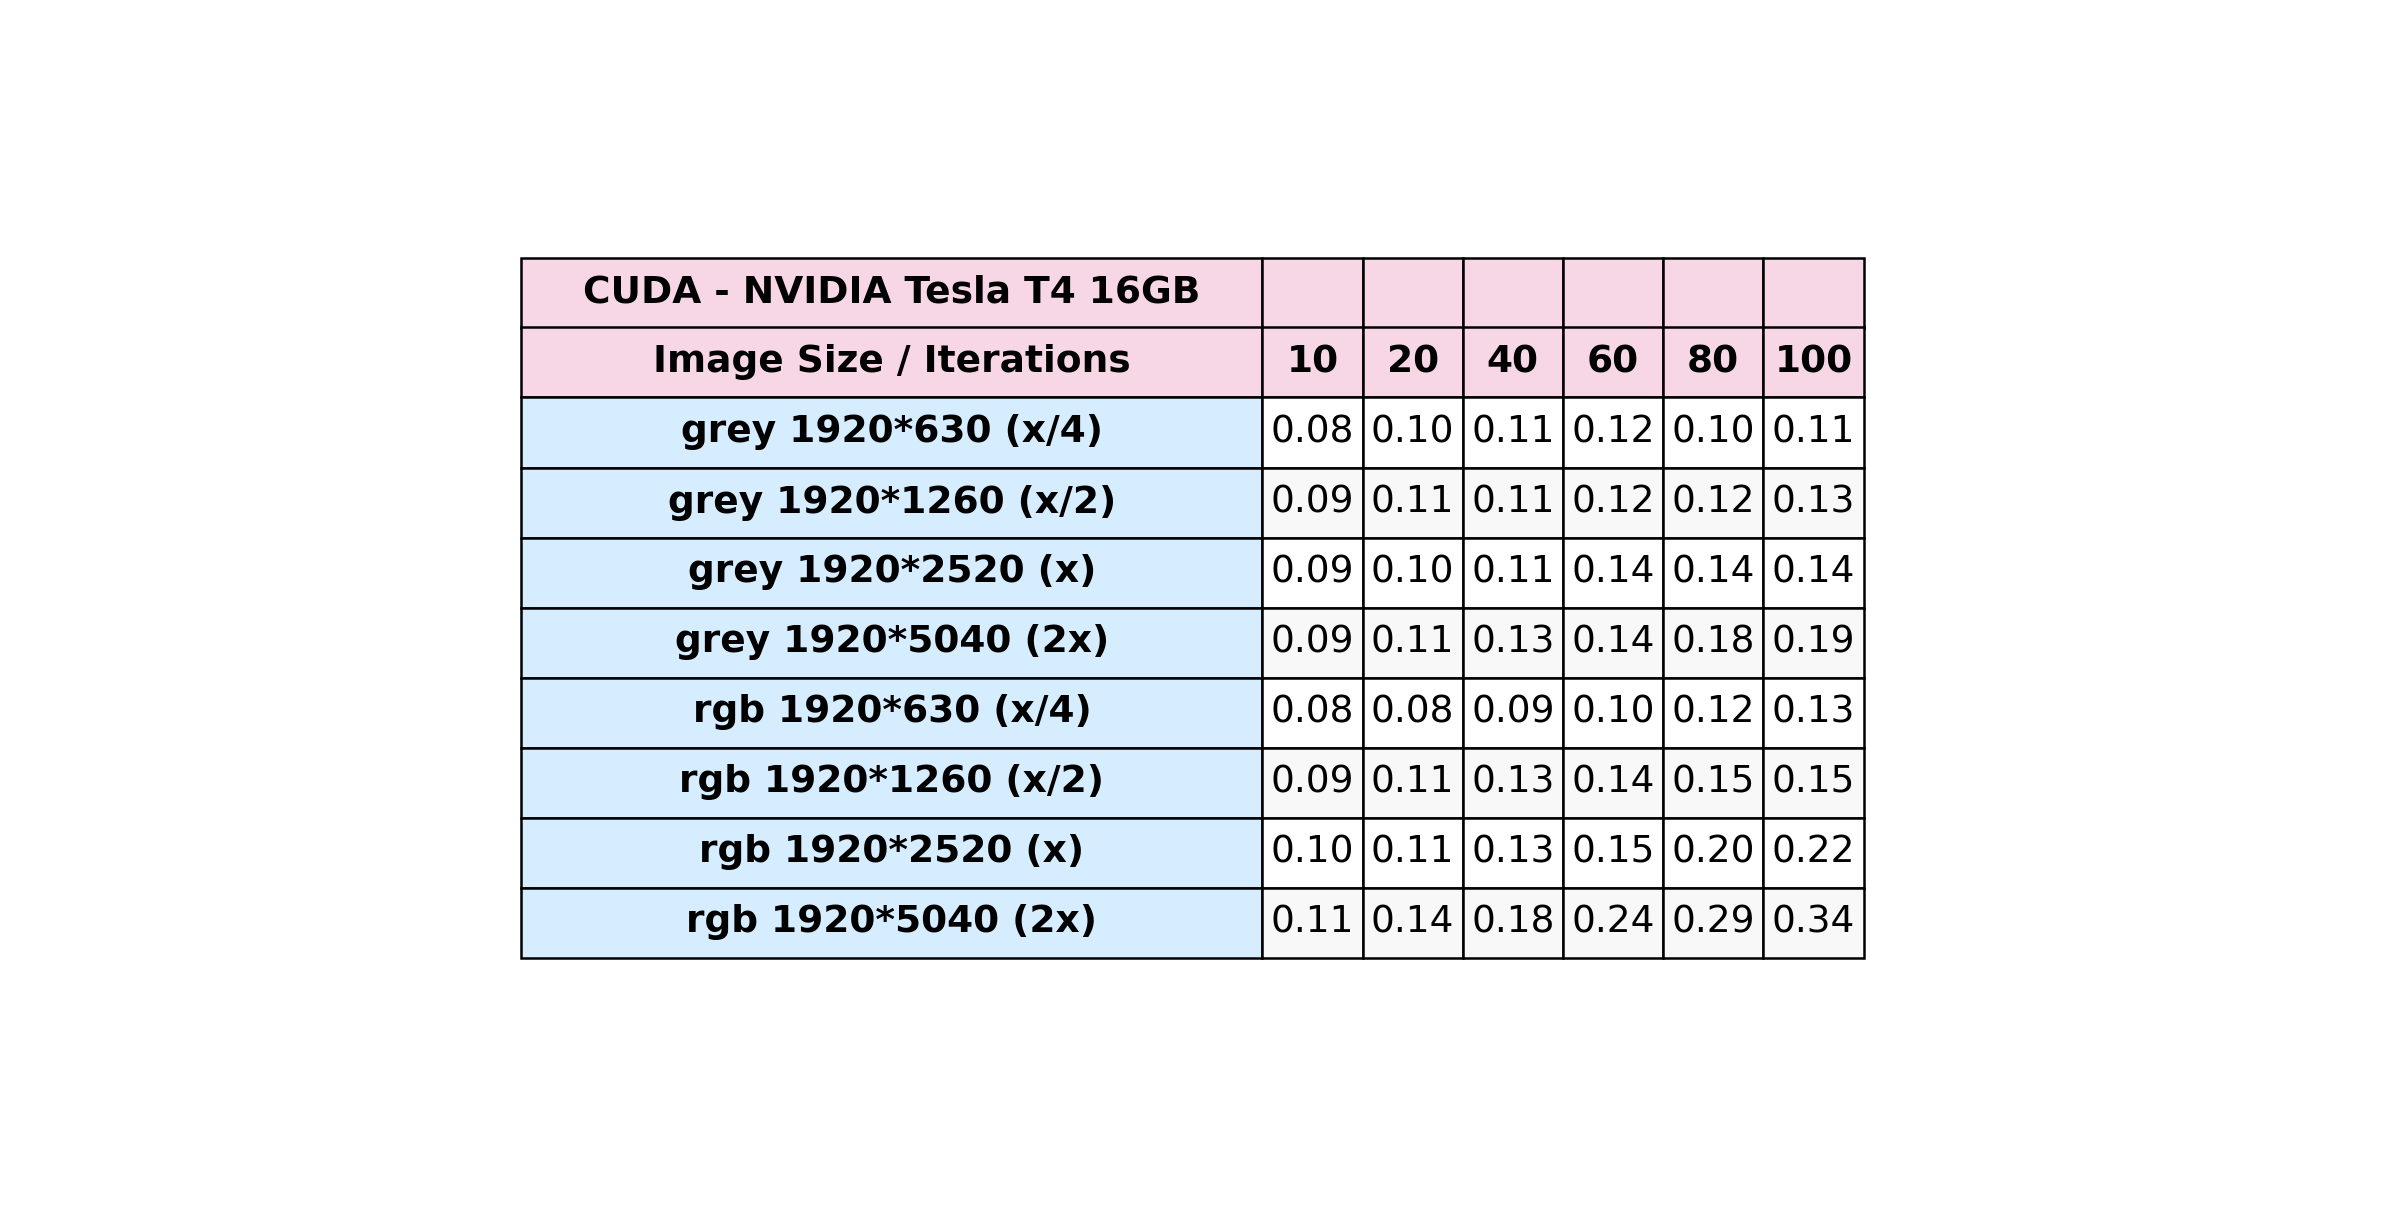

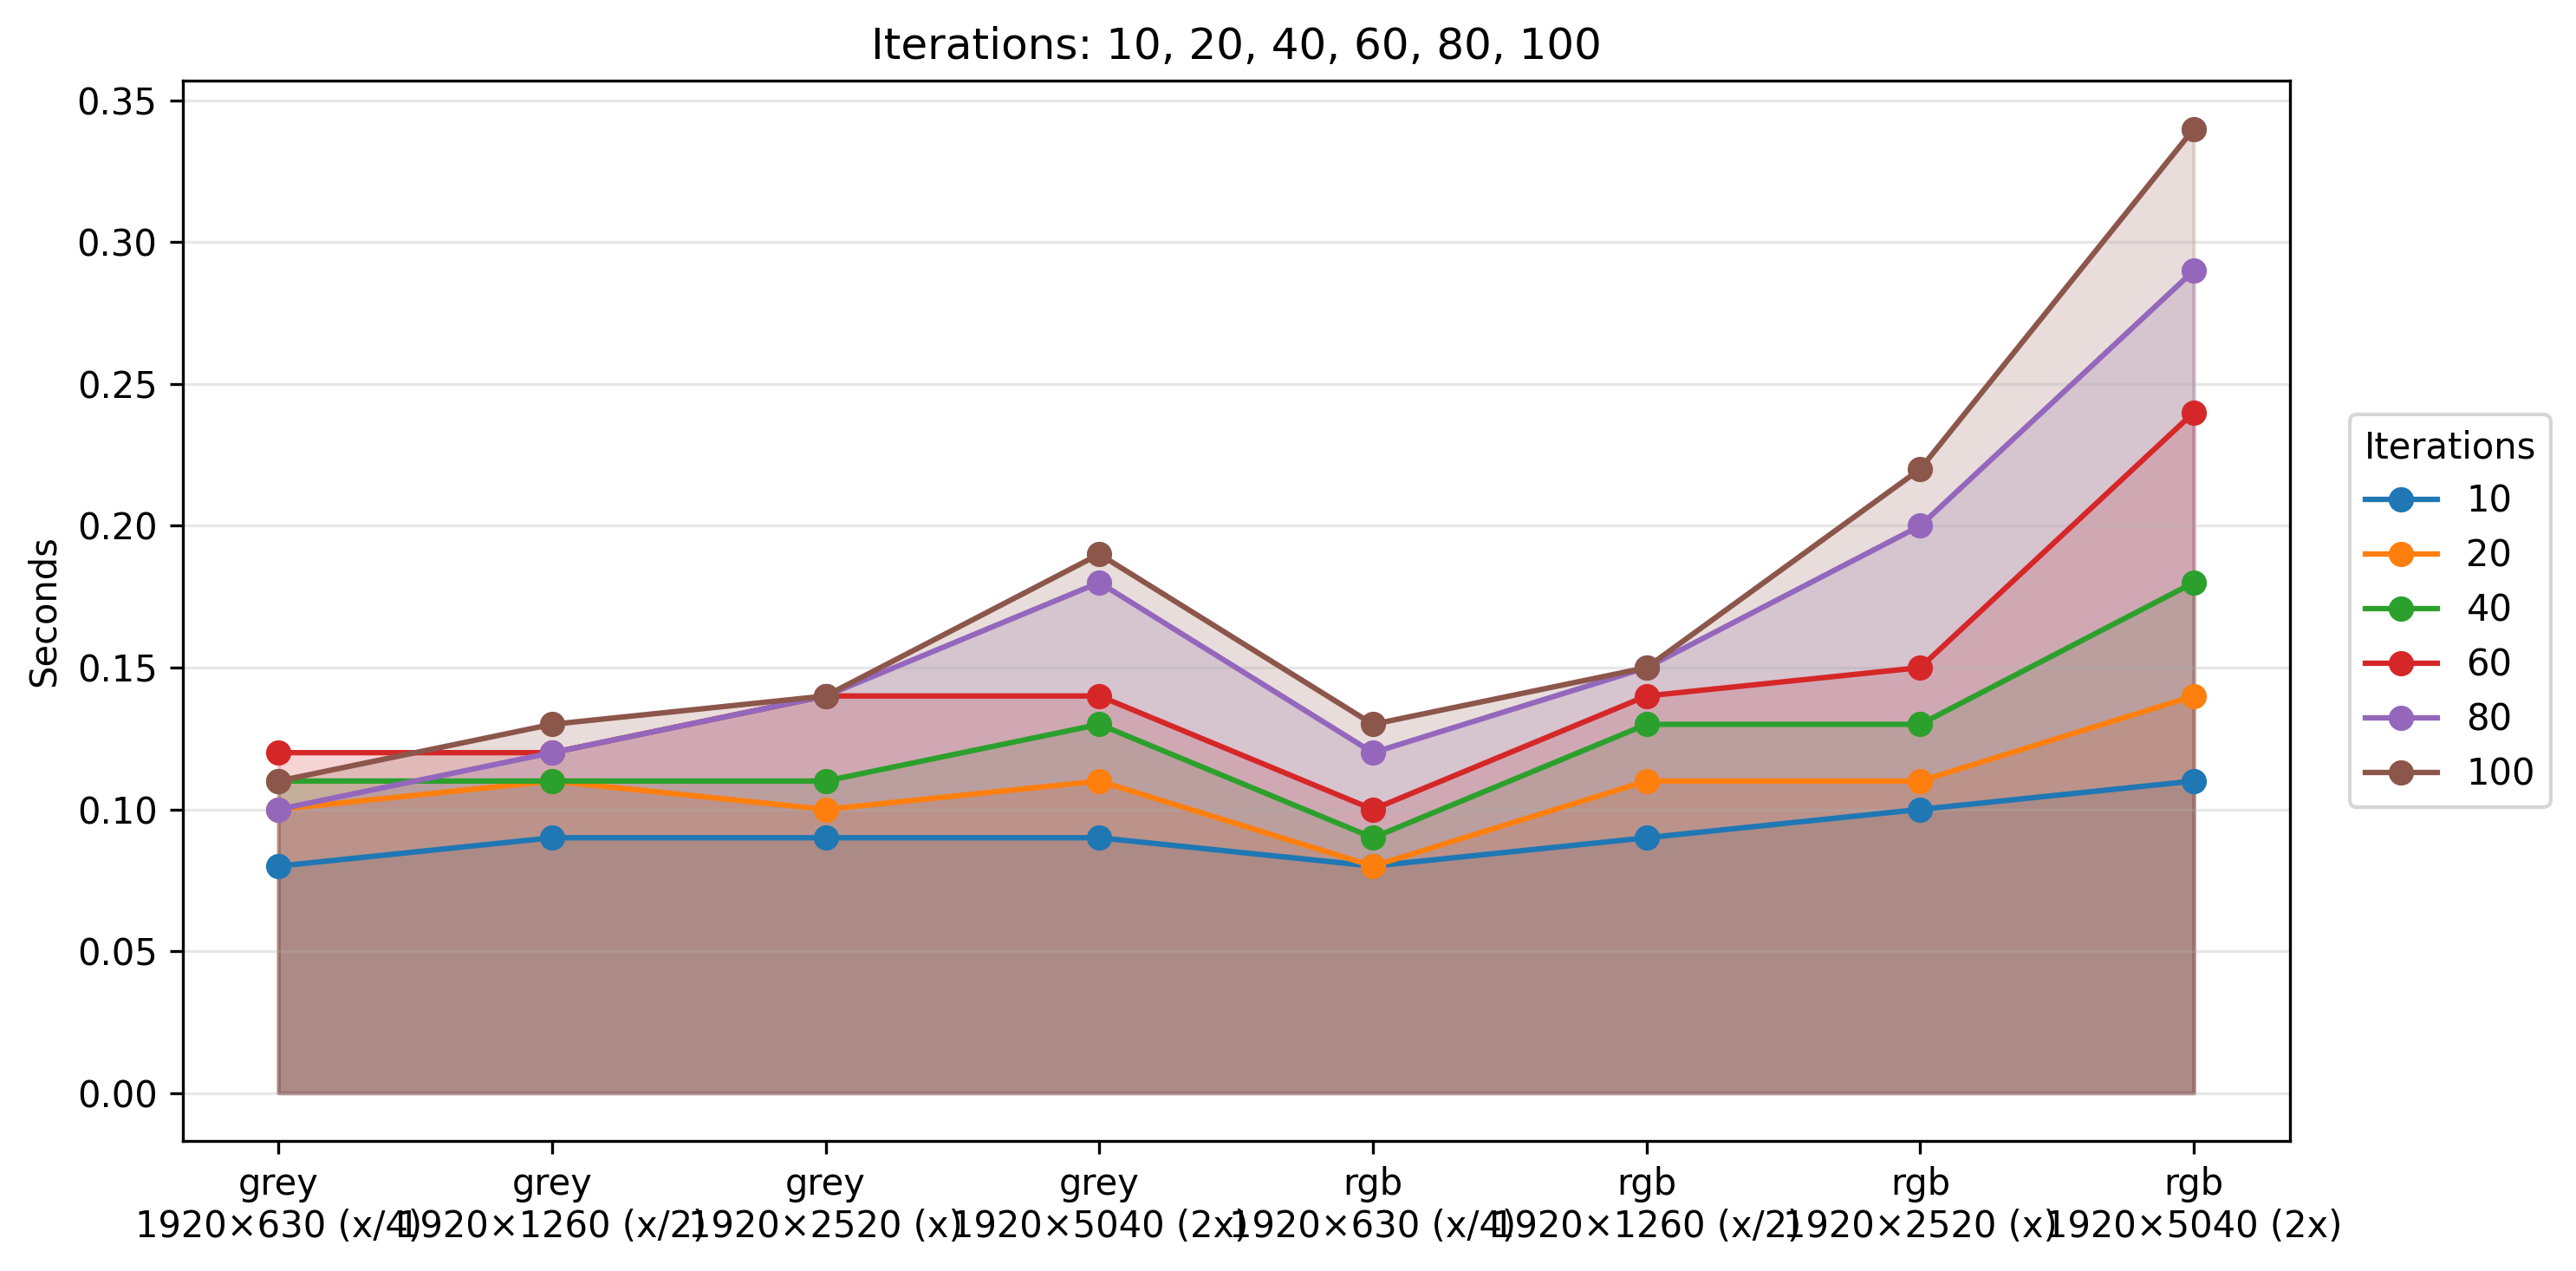

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

df = pd.read_csv("results/cuda_t4_times.csv", index_col=0)
iterations = list(df.columns)

# (A) Table image
header1 = ["CUDA - NVIDIA Tesla T4 16GB"] + [""] * len(iterations)
header2 = ["Image Size / Iterations"] + [str(c) for c in iterations]
cell_text = [header1, header2]
for idx, row in df.iterrows():
    cell_text.append([idx] + [f"{v:.2f}" for v in row])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis("off")

table = ax.table(cellText=cell_text, cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.4)

header_color = "#f7d6e6"
first_col_color = "#d6ecff"
zebra_color = "#f8f8f8"

for (r, c), cell in table.get_celld().items():
    cell.set_linewidth(0.6)
    if r in (0, 1):
        cell.set_facecolor(header_color)
        cell.set_text_props(weight="bold")
    elif c == 0:
        cell.set_facecolor(first_col_color)
        cell.set_text_props(weight="bold")
    else:
        if (r - 2) % 2 == 1:
            cell.set_facecolor(zebra_color)

for c in range(len(cell_text[0])):
    table.auto_set_column_width(c)

os.makedirs("results", exist_ok=True)
fig_table_path = "results/fig_cuda_t4_table.png"
fig.savefig(fig_table_path, dpi=300, bbox_inches="tight")
plt.close(fig)

# (B) Runtime chart
labels = []
for idx in df.index:
    mode, rest = idx.split(" ", 1)
    rest = rest.replace("*", "×")
    labels.append(f"{mode}\n{rest}")
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.tab10.colors

for i, it in enumerate(iterations):
    y = df[it].to_numpy(dtype=float)
    color = colors[i % len(colors)]
    ax.plot(x, y, marker="o", color=color, label=str(it))
    ax.fill_between(x, y, color=color, alpha=0.2)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Seconds")
ax.set_title("Iterations: 10, 20, 40, 60, 80, 100")
ax.grid(True, axis="y", alpha=0.3)
ax.legend(title="Iterations", bbox_to_anchor=(1.02, 0.5), loc="center left")
fig.tight_layout()

fig_runtime_path = "results/fig_cuda_t4_runtime.png"
fig.savefig(fig_runtime_path, dpi=300, bbox_inches="tight")
plt.close(fig)

# Display
print(fig_table_path)
print(fig_runtime_path)
display(Image(fig_table_path))
display(Image(fig_runtime_path))

## Optional correctness test (manual upload)
Set RUN_OPTIONAL = True to upload a .raw file and generate a blur_ output for visual checking. This is skipped during the benchmark.

In [56]:
RUN_OPTIONAL = False
if RUN_OPTIONAL:
    from google.colab import files

    uploaded = files.upload()
    if uploaded:
        image = next(iter(uploaded))
        width = 1920
        height = 2520
        loops = 50
        mode = "grey"  # "grey" or "rgb"

        !./cuda_conv
        files.download("blur_" + image)